In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.modeling_outputs import BaseModelOutput
from IPython.display import display, HTML
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

c:\Users\there\anaconda3\envs\llmproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/bart-large" # Recommend this one if your computer is okay with larger models
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

c:\Users\there\anaconda3\envs\llmproj\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
def add_noise_with_snr(encoder_output, target_snr_db):
    """
    Add noise to the encoder output based on a target SNR in dB.
    
    Parameters:
    - encoder_output: torch.Tensor, the encoder's output (last_hidden_state).
    - target_snr_db: float, the desired signal-to-noise ratio in dB.
    
    Returns:
    - noisy_encoder_output: torch.Tensor, encoder output with added noise.
    """
    # Convert SNR from dB to linear scale
    target_snr_linear = 10 ** (target_snr_db / 10)
    
    # Calculate power of the signal
    signal_power = torch.mean(encoder_output ** 2)
    
    # Calculate required noise power for the target SNR
    noise_power = signal_power / target_snr_linear
    noise = torch.randn_like(encoder_output) * torch.sqrt(noise_power)
    
    # Add noise to the encoder output
    noisy_encoder_output = encoder_output + noise
    return noisy_encoder_output

In [4]:
def generate_with_embeddings(input_text, encoder_outputs=None):
    """
    Generates text from input and returns both generated text and decoder embeddings.
    
    Parameters:
    - input_text: str, input text for the model
    - encoder_outputs: optional, allows custom encoder outputs to be fed into the decoder
    
    Returns:
    - generated_text: str, the generated text output
    - decoder_embeddings: torch.Tensor, embeddings for each token in the output sequence
    """
    # Encode input text
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    
    # Pass through encoder if no custom encoder outputs provided
    if encoder_outputs is None:
        encoder_outputs = model.model.encoder(input_ids=inputs.input_ids)
    else:
        # Copy the encoder_outputs to prevent accumulation (ChatGPT tells me to use clone(), otherwise the shape will mismatch later)
        encoder_outputs = BaseModelOutput(last_hidden_state=encoder_outputs.last_hidden_state.clone())
    
    # Generate with embeddings output
    outputs = model.generate(
        input_ids=None,  # Set None to use encoder_outputs
        encoder_outputs=encoder_outputs,
        output_hidden_states=True,
        return_dict_in_generate=True,
        max_length=500,
        min_length=10,
        do_sample=True,
        temperature=0.2
    )

    # Retrieve generated token IDs and decode to text
    generated_ids = outputs.sequences
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Collect the last decoder hidden states as embeddings
    '''
    !! Need to find out the difference between the below two lines, which one exactly should be returned
    '''
    # decoder_embeddings = outputs.decoder_hidden_states[-1][0]  # Shape: [sequence_length, hidden_size], ChatGPT tells me to return [-1][0]
    decoder_embeddings = torch.stack(outputs.decoder_hidden_states[-1]) # return [-1] and convert to torch.tensor, seems also fine.
    
    # Decode embeddings back to tokens
    decoded_tokens = [tokenizer.decode([token]) for token in generated_ids[0]]

    return generated_text, decoder_embeddings, decoded_tokens

In [7]:
original_text = """
Beginners BBQ Class Taking Place in Missoula! 
Do you want to get better at making delicious BBQ?
You will have the opportunity, put this on your calendar now. 
Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. 
He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. 
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. 
The cost to be in the class is $35 per person, and for spectators it is free. 
Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared. </s>
""".replace("\n", "") 
input_text = """
Beginners BBQ Class <mask> in Missoula! 
Do you want to <mask> making delicious BBQ?
You will have the opportunity, put this on your calendar now. 
Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. 
He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. 
He will teach you <mask> compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. 
The <mask> the class is $35 per person, and for spectators it is free. 
Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.
""".replace("\n", "")

# original_text = """
# This November, embark on an exciting hiking adventure! 
# Explore the scenic mountain trails with an experienced guide, who will show you the best routes and hidden viewpoints. 
# This journey is suitable for all levels, from beginners to advanced hikers. 
# The hike covers approximately 10 miles and includes multiple rest stops with breathtaking views. 
# Participants should bring water, snacks, and comfortable hiking shoes. 
# The cost of the trip is $60, which includes a map and a group photo.
# """.replace("\n", "") 
# input_text = """
# This November, embark on an exciting <mask> adventure! 
# Explore the scenic mountain trails with an experienced guide, who will show you the best routes and hidden <mask>. 
# This journey is suitable for all levels, from beginners to advanced <mask>. 
# The hike covers approximately 10 miles and includes multiple rest stops with breathtaking <mask>. 
# Participants should bring water, snacks, and comfortable hiking shoes. 
# The <mask> is $60, which includes a map and a group photo.
# """.replace("\n", "")

# original_text = """
# Welcome to our online coding bootcamp program! 
# Whether you're a complete beginner or looking to improve your programming skills, this course is designed for you. 
# Throughout the course, you will learn essential coding languages such as Python and JavaScript. 
# Our instructors will guide you through interactive projects and provide real-time feedback. 
# Each student will receive a certificate of completion at the end of the program. 
# The total cost for the bootcamp is $150, which includes all learning materials.
# """.replace("\n", "") 
# input_text = """
# Welcome to our online <mask> bootcamp program! 
# Whether you're a complete beginner or looking to <mask> your programming skills, this course is designed for you. 
# Throughout the course, you will learn essential <mask> such as Python and JavaScript. 
# Our instructors will guide you through interactive projects and provide real-time <mask>. 
# Each student will receive a certificate of completion at the end of the <mask>. 
# The total cost for the bootcamp is $150, which <mask> all learning materials.
# """.replace("\n", "") 

### </s> signaling the end of the text, better to add one

In [6]:
target_snr = 10  # Define a target SNR for noise

# Get encoder outputs
with torch.no_grad():
    encoder_outputs = model.model.encoder(input_ids=tokenizer(input_text, return_tensors="pt").input_ids.to(device))

# Generate text with clean and noisy encoder outputs
baseline_text, baseline_embeddings, baseline_tokens = generate_with_embeddings(input_text, encoder_outputs=encoder_outputs)

# Generate with noisy encoder output
noisy_encoder_output = add_noise_with_snr(encoder_outputs.last_hidden_state, target_snr)
modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output)
noisy_text, noisy_embeddings, noisy_tokens = generate_with_embeddings(input_text, encoder_outputs=modified_encoder_outputs)

#original text
original2_text, original_embeddings, original_tokens = generate_with_embeddings(original_text, encoder_outputs=encoder_outputs)


# # Display results
print("Original Generated Text:\n", original_text)
print("\nBaseline Generated Text:\n", baseline_text)
# print("Baseline Decoder Embeddings Shape:", baseline_embeddings.shape)
# print("Baseline Decoded Tokens:", baseline_tokens)

print("\nGenerated Text with Noise:\n", noisy_text)
# print("Noisy Decoder Embeddings Shape:", noisy_embeddings.shape)
# print("Noisy Decoded Tokens:", noisy_tokens)

Original Generated Text:
 Beginners BBQ Class Taking Place in Missoula! Do you want to get better at making delicious BBQ?You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills. He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information. The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared. </s>

Baseline Generated Text:
 Beginners BBQ Class at Lonestar Smoke Rangers in Missoula!Do you love BBQ? Do you want to learn more about making delicious BBQ?You will have the opportunity, put this on your calendar now. Thurs

In [8]:
# Compute Cosine Similarity
cosine_similarities = F.cosine_similarity(noisy_embeddings, original_embeddings, dim=-1)
# print("Cosine similarities for each token:", cosine_similarities)
average_cosine_similarity = cosine_similarities.mean().item()
print("Average cosine similarity:", average_cosine_similarity)

Average cosine similarity: 0.45365291833877563


### Mutual Information

In [6]:
#using NPEET (referenced in MI paper) to calculate MI
from npeet import entropy_estimators as ee
import numpy as np

In [7]:
def ksg(x, y, k=3):
    #This function is taken from the github of mutual information paper.
    """
    Kraskov–Stogbauer–Grassberger (KSG) estimator of mutual information
    between two sentences represented as word embedding matrices x and y
    :param x: list of word embeddings for the first sentence
    :param y: list of word embeddings for the second sentence
    :return: KSG similarity measure between the two sentences
    """
    



    return ee.mi(x.T, y.T,k=3, base=np.e)


In [19]:
#test MI calculation
mi_sim = ksg(noisy_embeddings, original_embeddings)
print(mi_sim)

0.9424364245948036


In [25]:
# Define SNR range
snr_range = list(range(-20, 21, 1)) + list(range(22, 61, 2)) + list(range(64, 101, 4))  # From -20 to 100, with different resolution
cosine_similarities_list = []
mi_similarities_list = []

# Generate baseline (noise-free) encoder outputs
with torch.no_grad():
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    encoder_outputs = model.model.encoder(input_ids=input_ids)
    
# Generate baseline embeddings
baseline_text, baseline_embeddings, baseline_tokens = generate_with_embeddings(input_text, encoder_outputs=encoder_outputs)

# Iterate over SNR values and calculate cosine similarity for each
for target_snr in snr_range:
    # Add noise to encoder outputs with the current SNR level
    noisy_encoder_output = add_noise_with_snr(encoder_outputs.last_hidden_state, target_snr)
    modified_encoder_outputs = BaseModelOutput(last_hidden_state=noisy_encoder_output)
    
    # Generate output embeddings with noisy encoder outputs
    noisy_text, noisy_embeddings, noisy_tokens = generate_with_embeddings(input_text, encoder_outputs=modified_encoder_outputs)
    
    # Calculate cosine similarity for each token and then compute the average
    cosine_similarities = F.cosine_similarity(noisy_embeddings, baseline_embeddings, dim=-1)
    average_cosine_similarity = cosine_similarities.mean().item()
    cosine_similarities_list.append(average_cosine_similarity)
    
    # Calc MI similarity
    mi_sim = ksg(noisy_embeddings, baseline_embeddings)
    mi_similarities_list.append(mi_sim.mean().item())
    
    
    

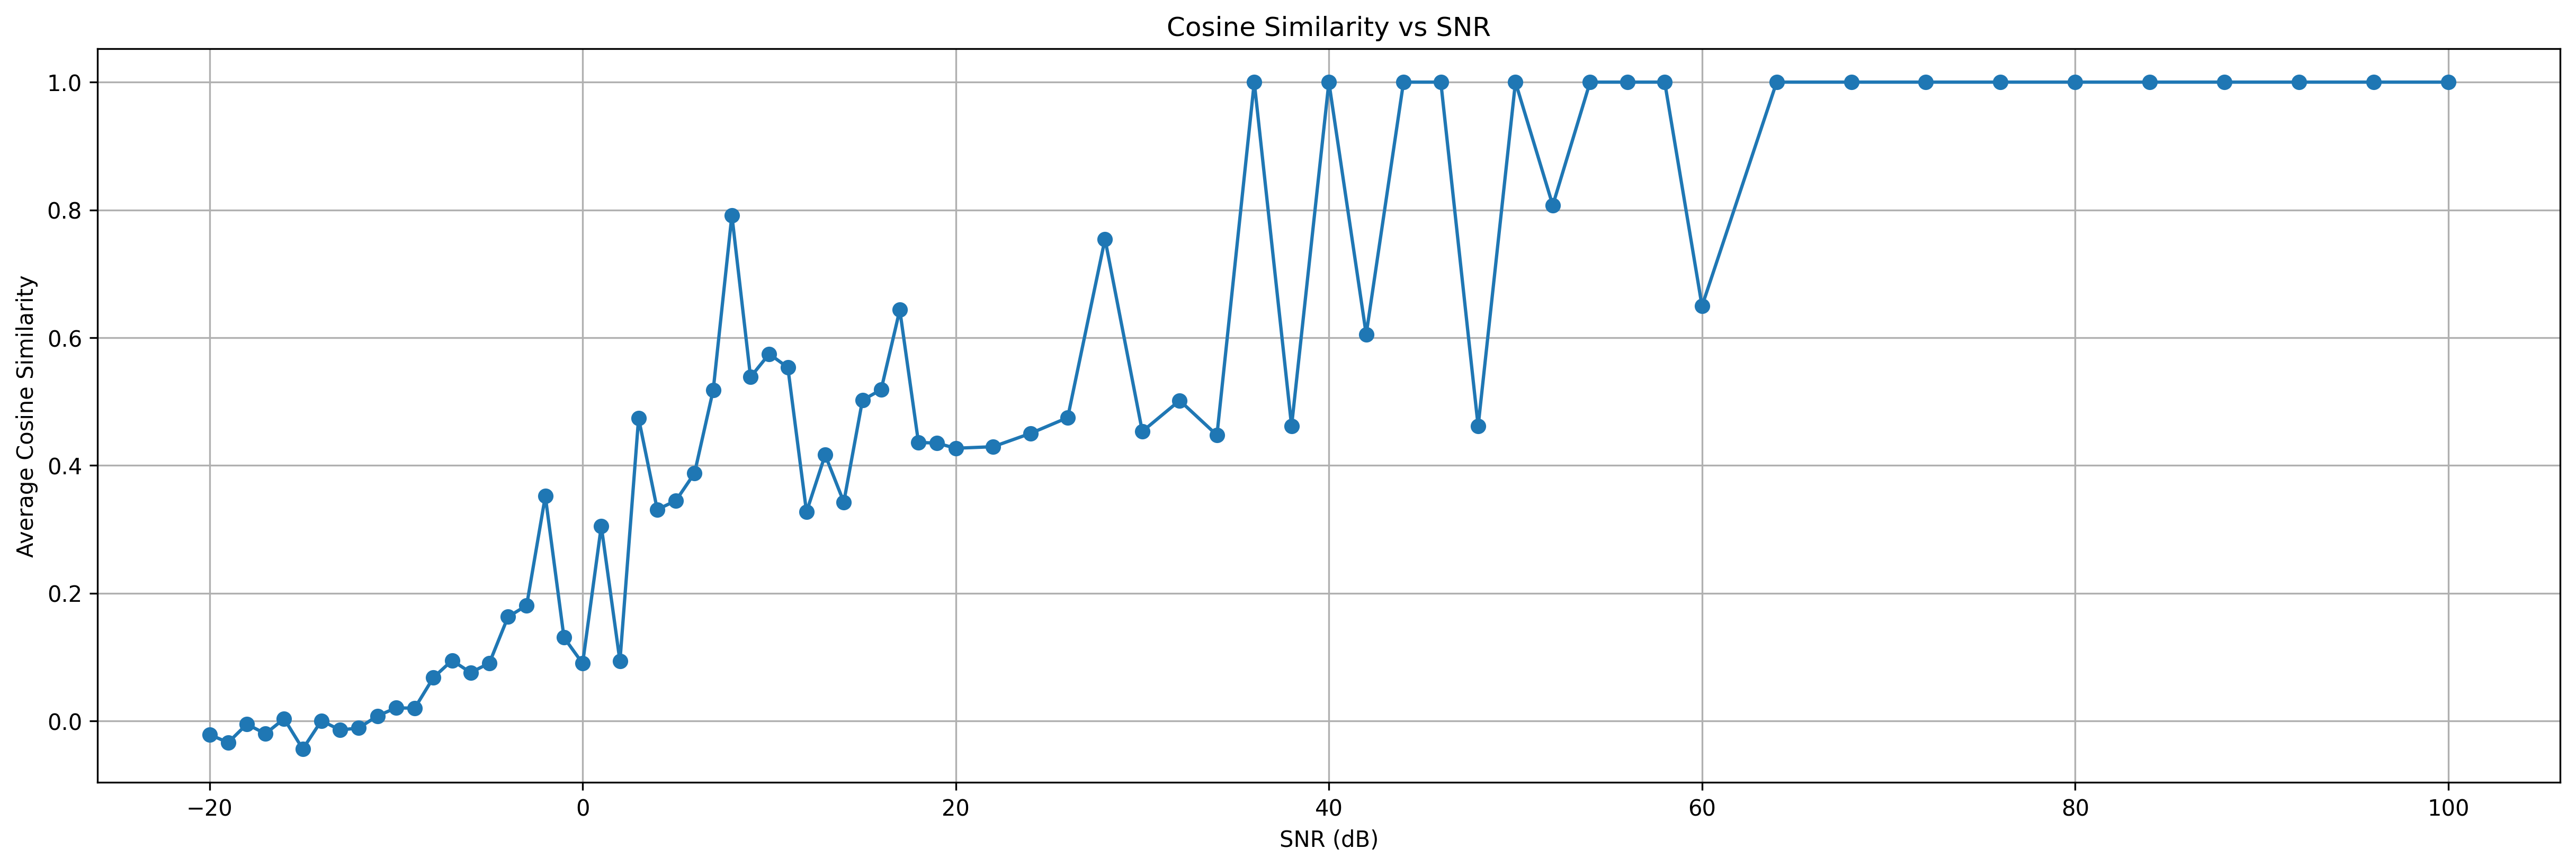

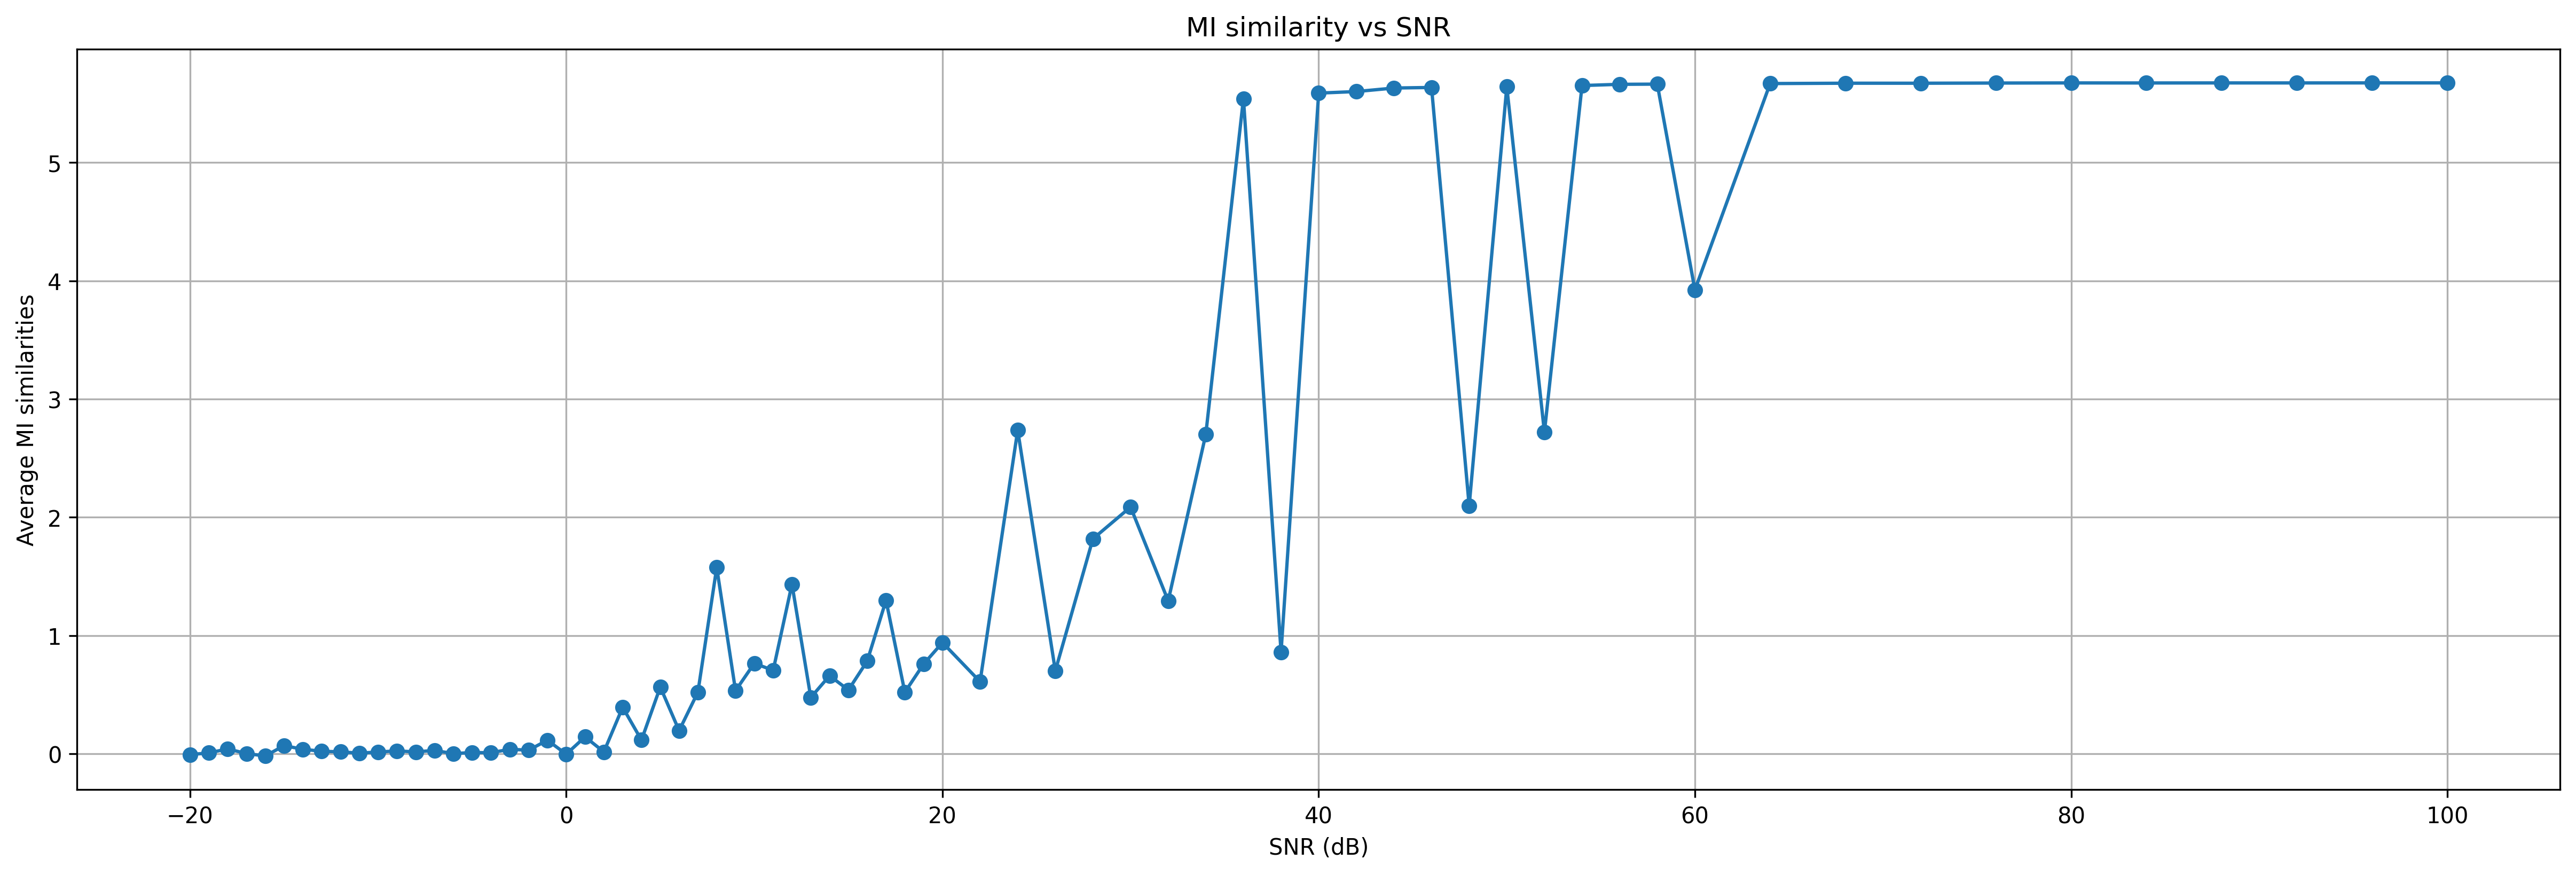

In [28]:
# # Plot of cosine similarity (decoder_embeddings = torch.stack(outputs.decoder_hidden_states[-1]) from `generate_with_embeddings`); input_text = "Beginners BBQ Class Taking Place in Missoula! "
plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, cosine_similarities_list, marker='o')

plt.xlabel("SNR (dB)")
plt.ylabel("Average Cosine Similarity")
plt.title("Cosine Similarity vs SNR")
plt.grid()
plt.show()

plt.figure(figsize=(20, 6), dpi=300)
plt.plot(snr_range, mi_similarities_list, marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Average MI similarities")
plt.title("MI similarity vs SNR")
plt.grid()
plt.show()



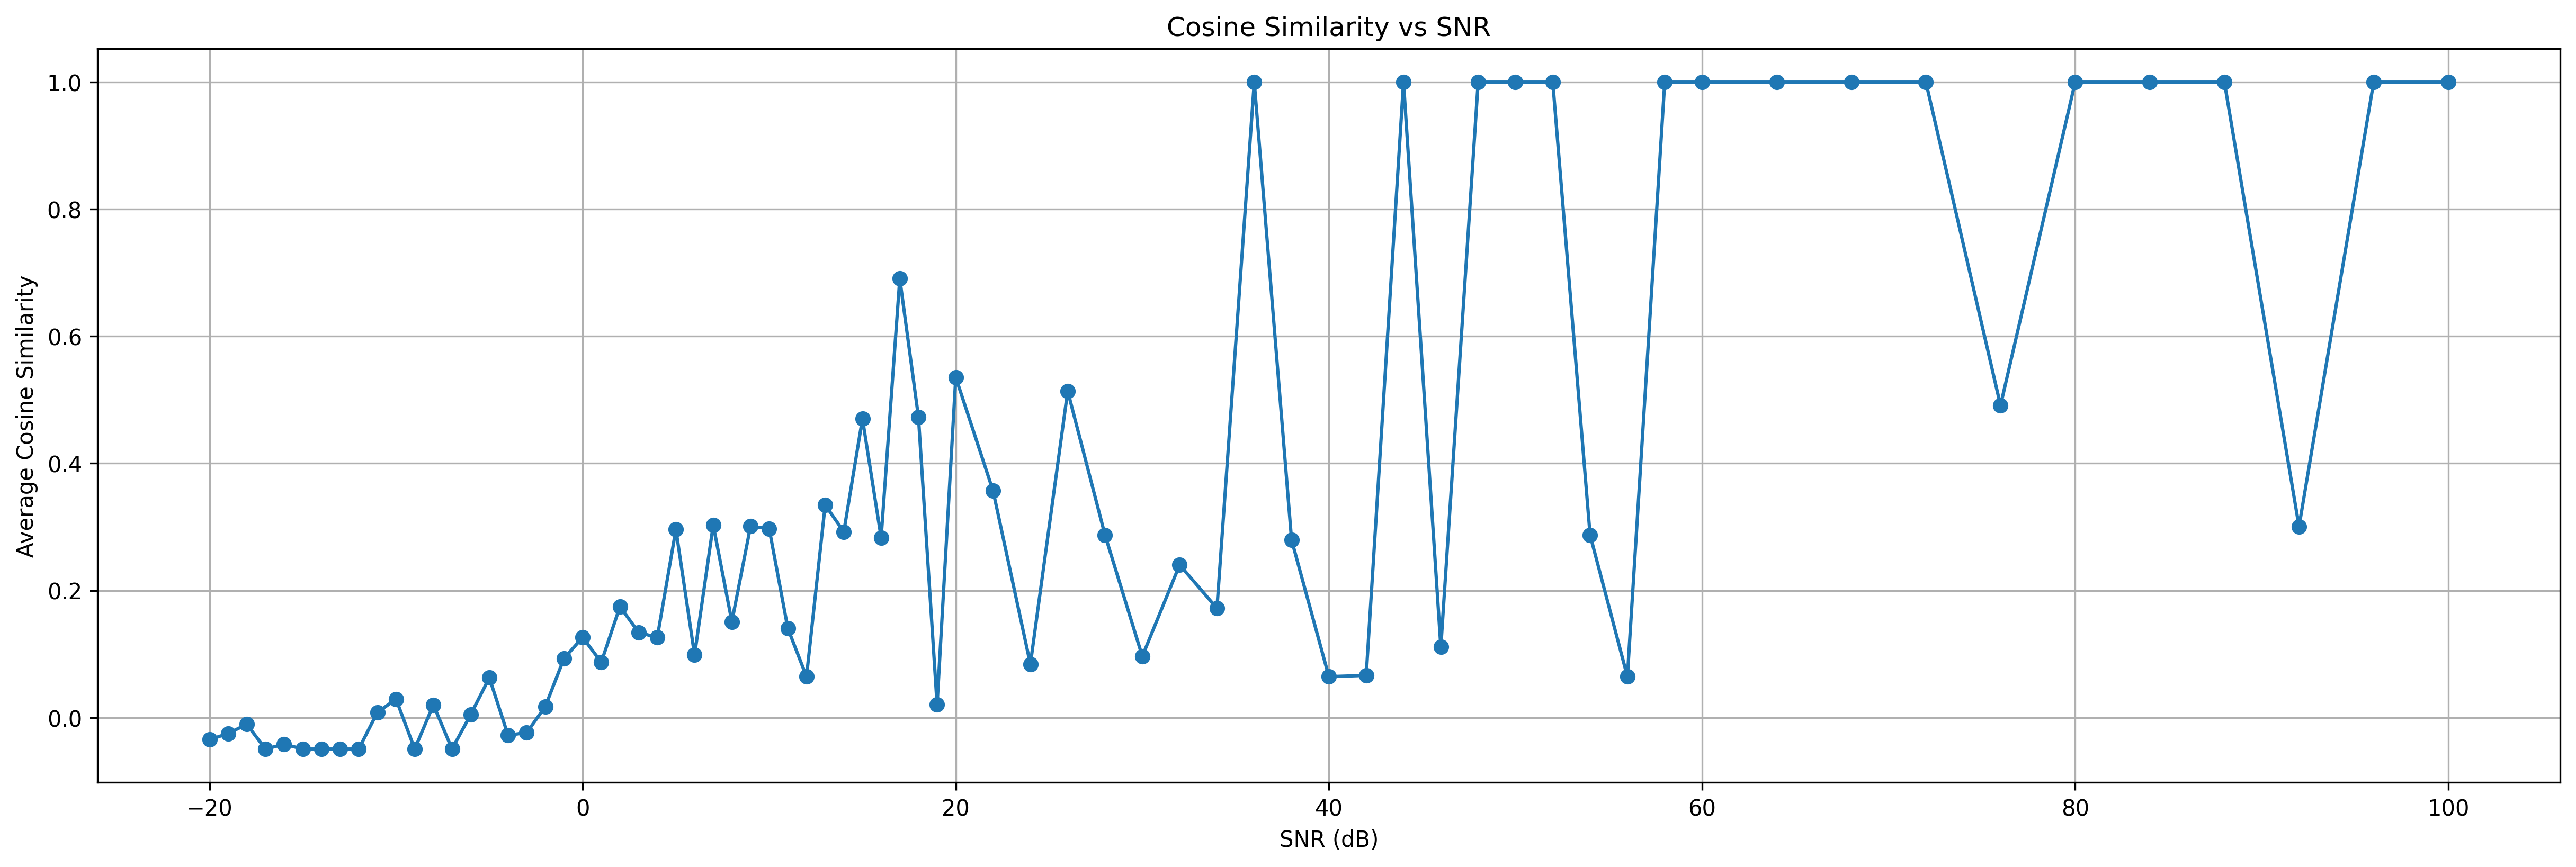

In [137]:
# # Plot of cosine similarity (decoder_embeddings = outputs.decoder_hidden_states[-1][0] from `generate_with_embeddings`); input_text = "Beginners BBQ Class Taking Place in Missoula! "
# plt.figure(figsize=(20, 6), dpi=300)
# plt.plot(snr_range, cosine_similarities_list, marker='o')
# plt.xlabel("SNR (dB)")
# plt.ylabel("Average Cosine Similarity")
# plt.title("Cosine Similarity vs SNR")
# plt.grid()
# plt.show()

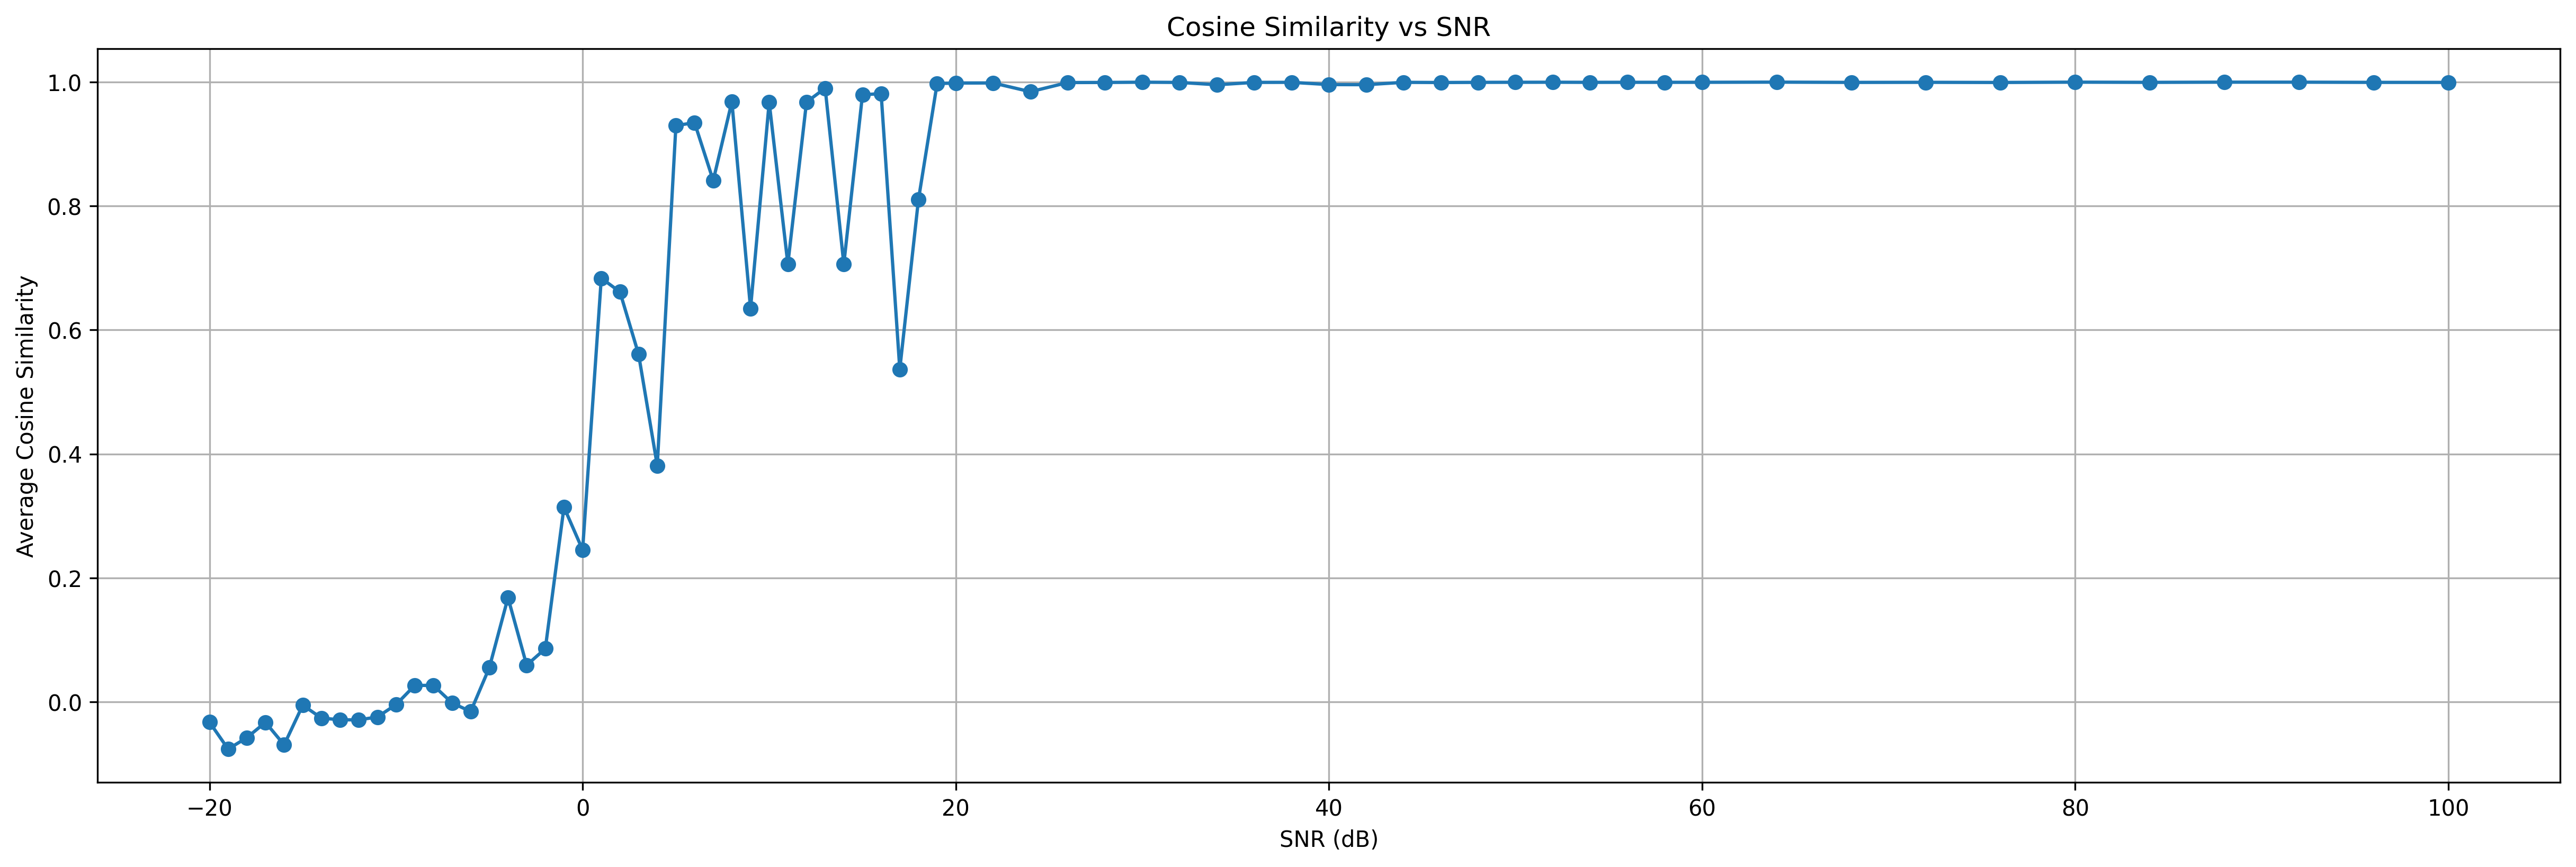

In [126]:
# # Plot of cosine similarity (decoder_embeddings = torch.stack(outputs.decoder_hidden_states[-1]) from `generate_with_embeddings`); input_text = "This November, embark on an exciting hiking adventure!"
# plt.figure(figsize=(20, 6), dpi=300)
# plt.plot(snr_range, cosine_similarities_list, marker='o')
# plt.xlabel("SNR (dB)")
# plt.ylabel("Average Cosine Similarity")
# plt.title("Cosine Similarity vs SNR")
# plt.grid()
# plt.show()

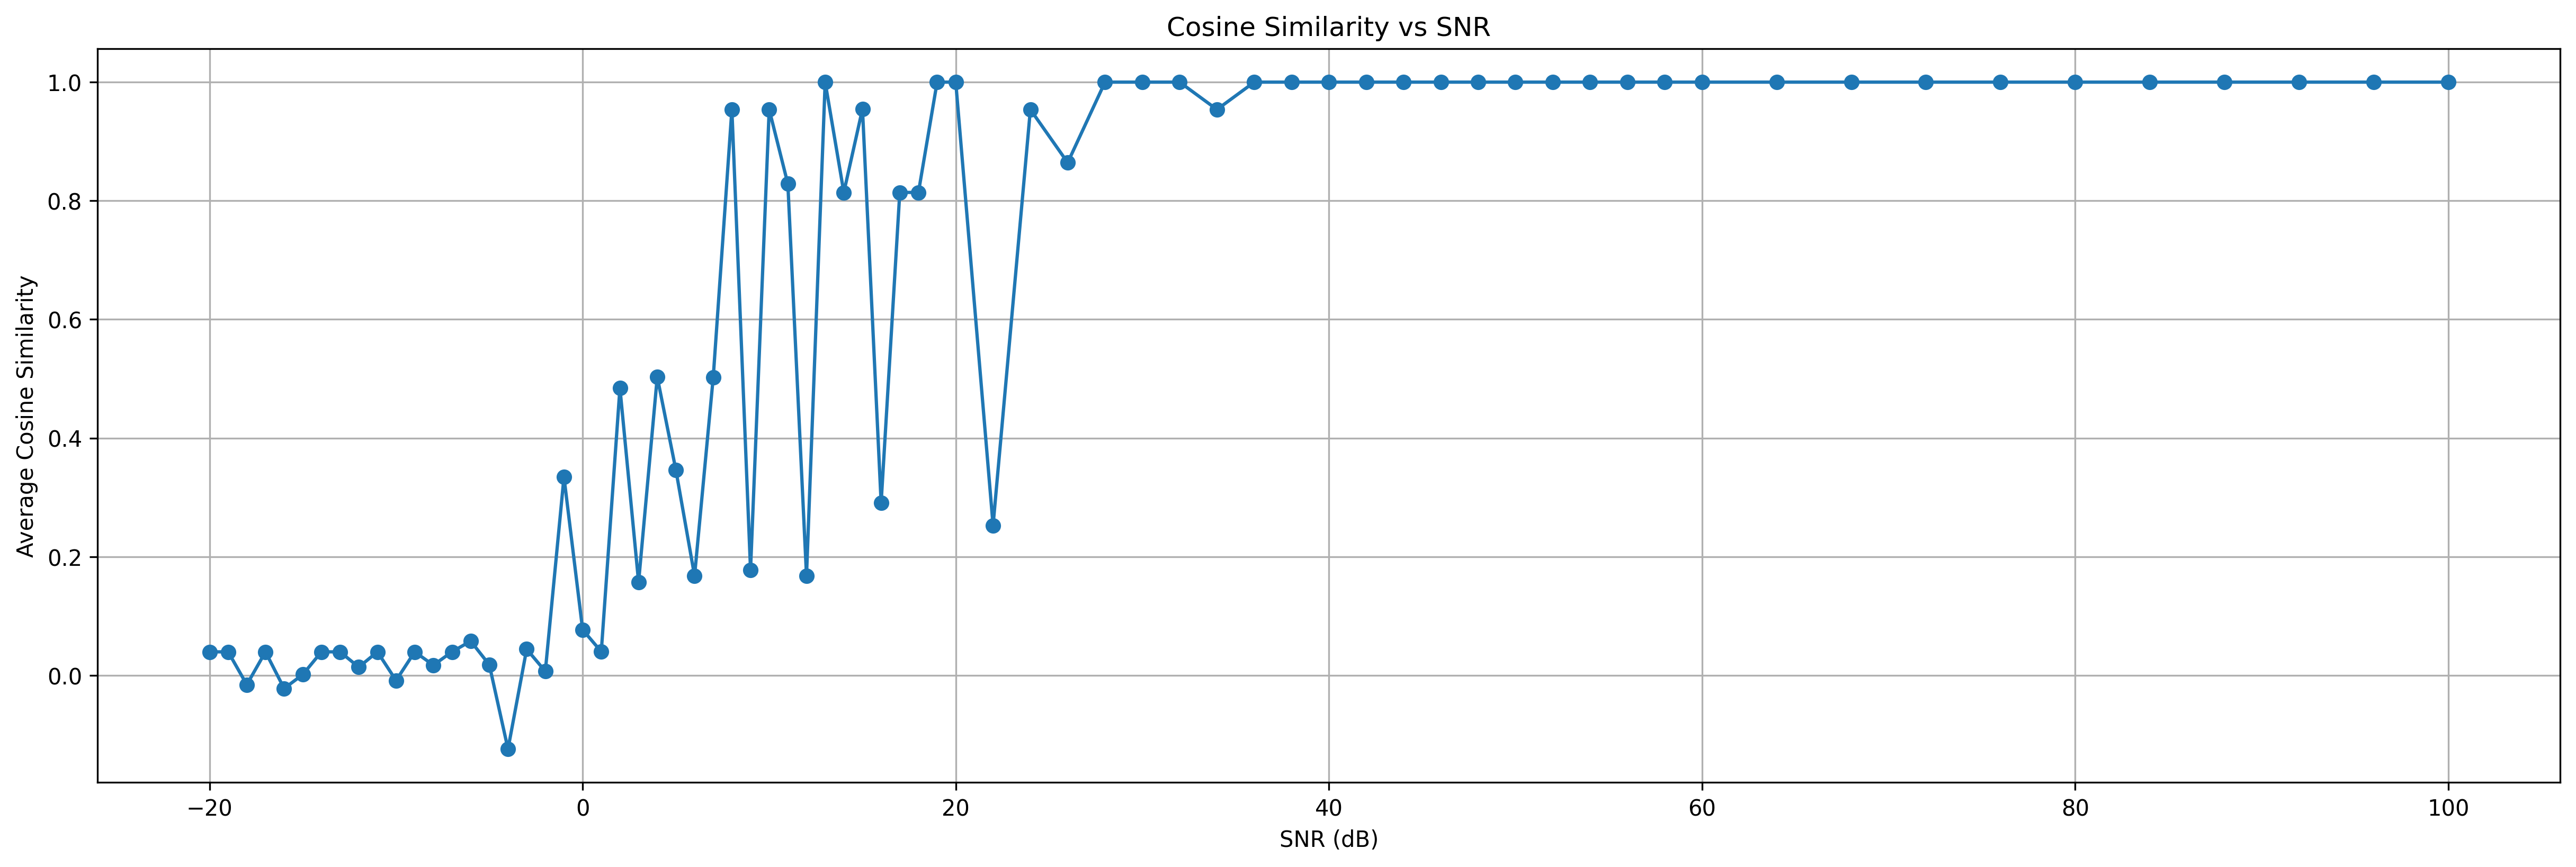

In [119]:
# # Plot of cosine similarity (decoder_embeddings = outputs.decoder_hidden_states[-1][0] from `generate_with_embeddings`); input_text = "This November, embark on an exciting hiking adventure!"
# plt.figure(figsize=(20, 6), dpi=300)
# plt.plot(snr_range, cosine_similarities_list, marker='o')
# plt.xlabel("SNR (dB)")
# plt.ylabel("Average Cosine Similarity")
# plt.title("Cosine Similarity vs SNR")
# plt.grid()
# plt.show()

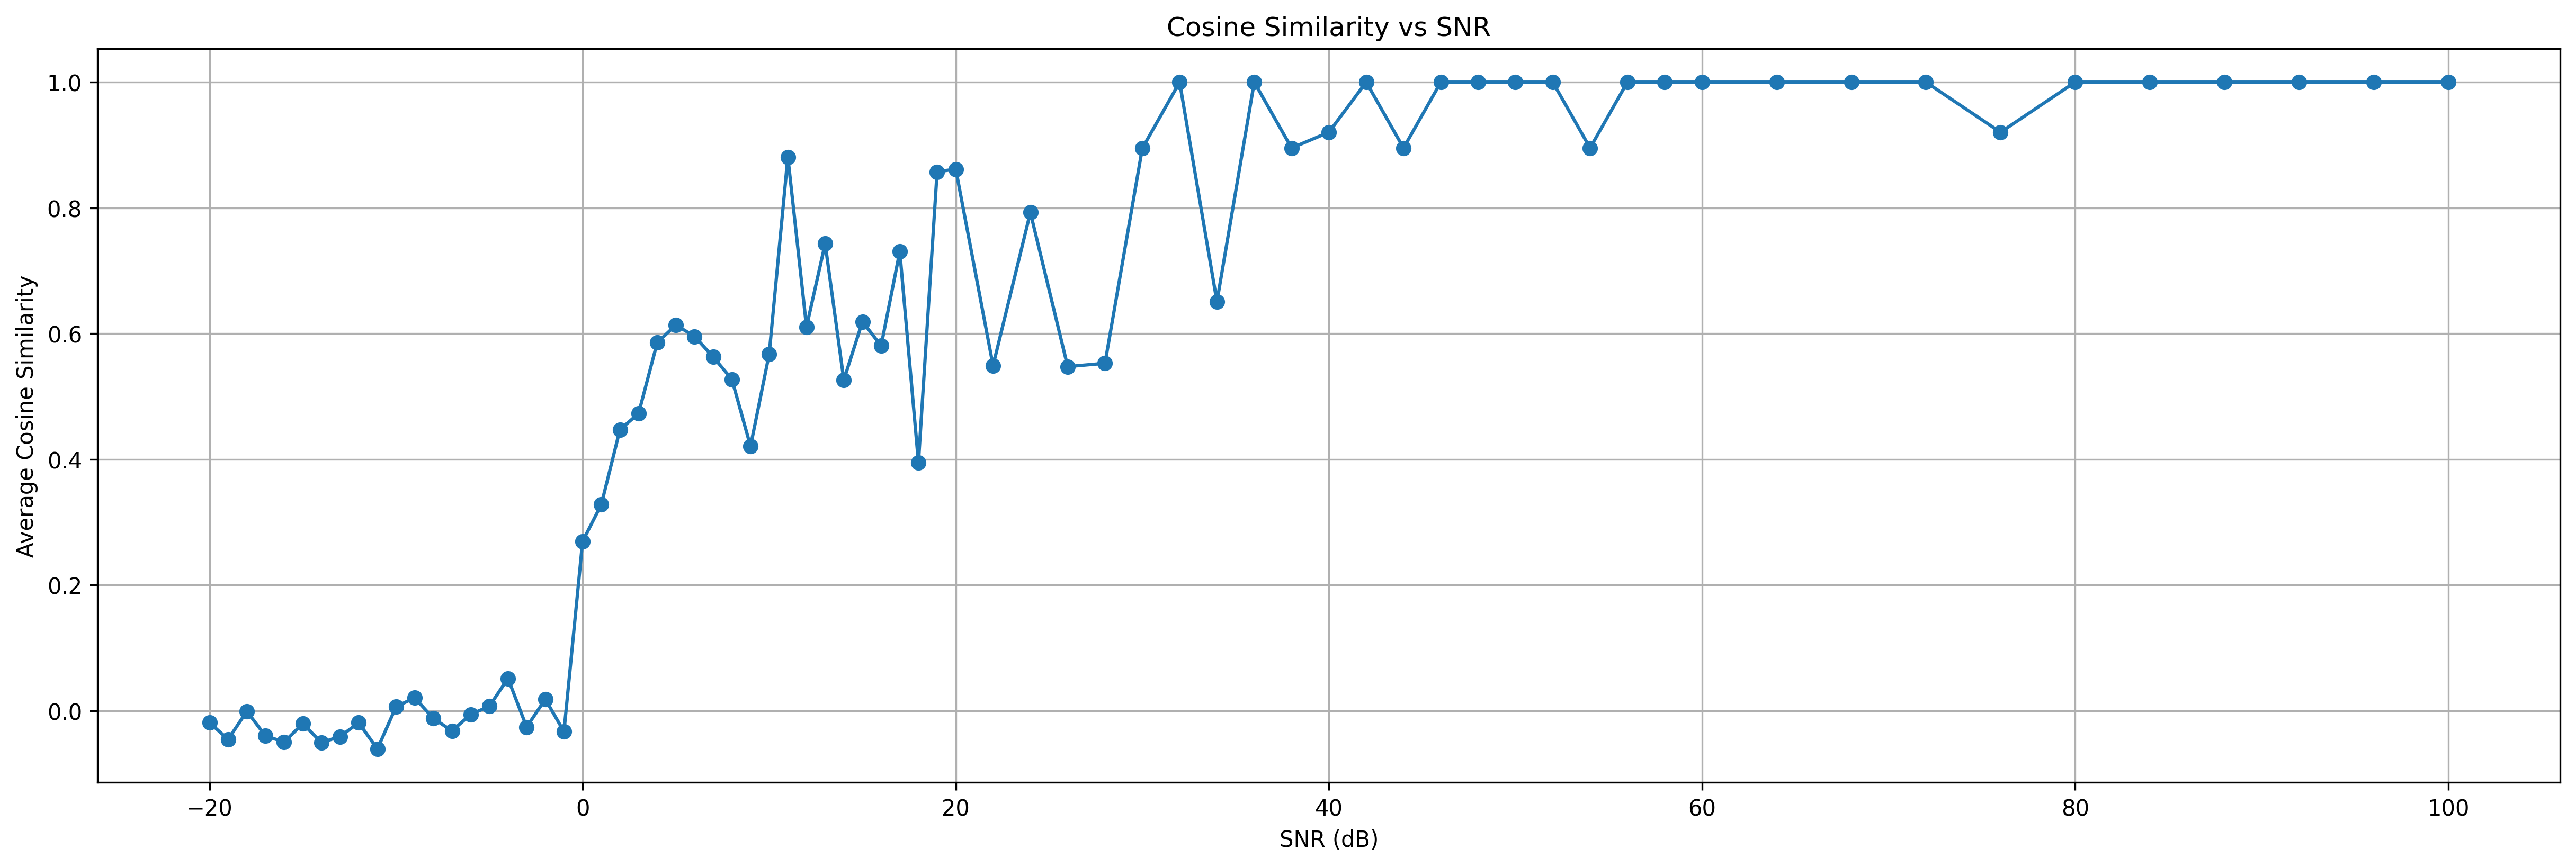

In [101]:
# # Plot of cosine similarity (decoder_embeddings = torch.stack(outputs.decoder_hidden_states[-1]) from `generate_with_embeddings`); input_text = "Welcome to our online coding bootcamp program!"
# plt.figure(figsize=(20, 6), dpi=300)
# plt.plot(snr_range, cosine_similarities_list, marker='o')
# plt.xlabel("SNR (dB)")
# plt.ylabel("Average Cosine Similarity")
# plt.title("Cosine Similarity vs SNR")
# plt.grid()
# plt.show()

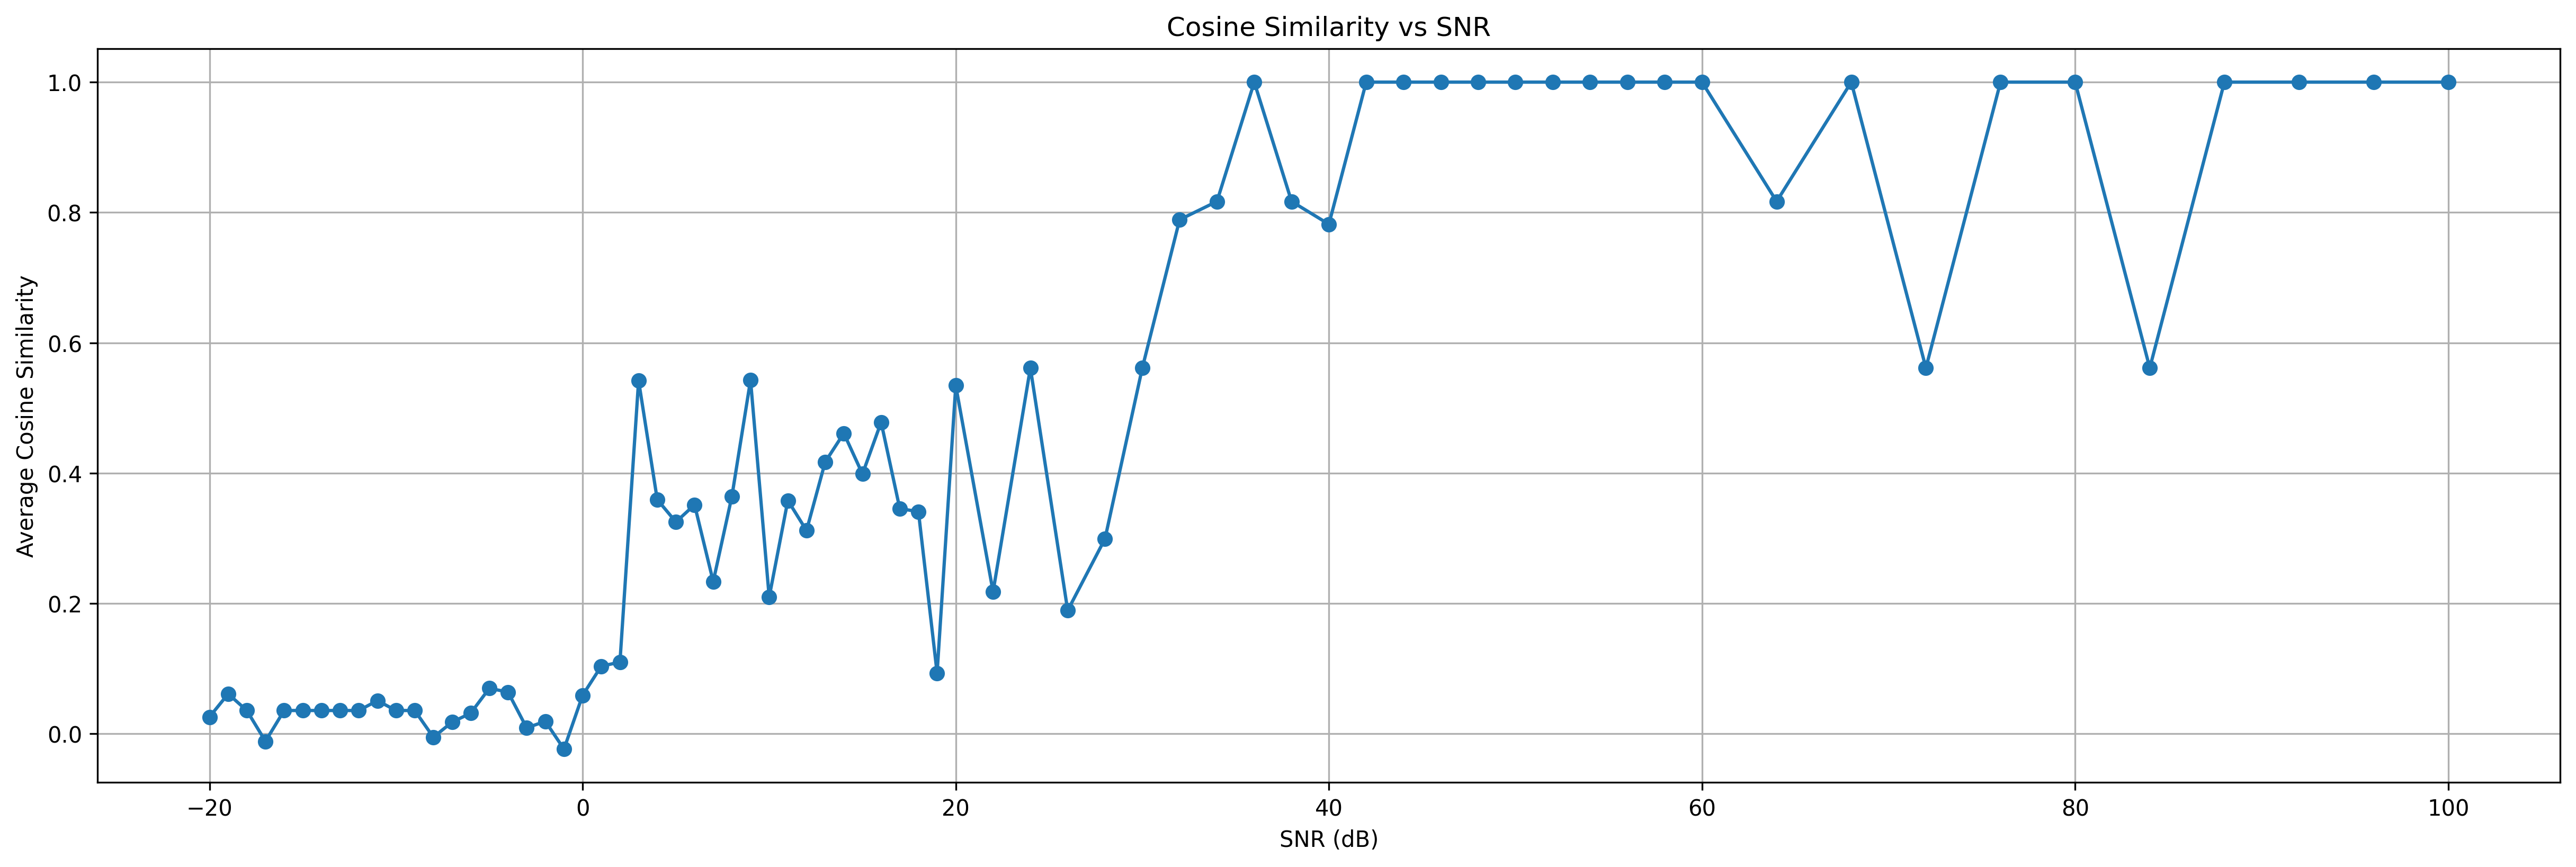

In [111]:
# # Plot of cosine similarity (decoder_embeddings = outputs.decoder_hidden_states[-1][0] from `generate_with_embeddings`); input_text = "Welcome to our online coding bootcamp program!"
# plt.figure(figsize=(20, 6), dpi=300)
# plt.plot(snr_range, cosine_similarities_list, marker='o')
# plt.xlabel("SNR (dB)")
# plt.ylabel("Average Cosine Similarity")
# plt.title("Cosine Similarity vs SNR")
# plt.grid()
# plt.show()